# CSCI-UA 0473 - Introduction to Machine Learning
## Wednesday, April 11, 2018

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.sparse import diags
%matplotlib inline

from sklearn import datasets
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import autograd
import autograd.numpy as numpy
import autograd.numpy.random as npr

from autograd import grad

import scipy.optimize

## 1. Data

In [2]:
newsgroups_train = datasets.fetch_20newsgroups(subset='train', 
                                               categories=['comp.sys.mac.hardware', 'rec.motorcycles', 'sci.med', 'soc.religion.christian'])

In [3]:
tfidf_vectorizer = TfidfVectorizer(min_df=30, stop_words='english')
X = tfidf_vectorizer.fit_transform(newsgroups_train.data).toarray()
y = newsgroups_train.target
print (X.shape)

(2369, 1529)


In [4]:
X = np.transpose(X)

def normalize(data):
    mean = np.mean(data, axis=1)[:,None]
    return data - mean

(d, N) = X.shape
q = 10

print ("d",  d)
print ("N", N)
print ("q", q)

print ("X", (d, N))
print ("W", (d, q))
print ("Z", (q, N))
# X : (d, N)
# W : (d, q)
# Z : (q, N)

d 1529
N 2369
q 10
X (1529, 2369)
W (1529, 10)
Z (10, 2369)


In [5]:
choose_which = "nmf"
# "compute_c", "svd", "sgd", "nmf"

In [6]:
if choose_which == "nmf":
    X = X - np.min(X)
else:
    X = normalize(X)

In [7]:
if choose_which == "svd":
    W, S, V = linalg.svd(X)
    print ("X", X.shape)
    print ("W", W.shape)
    print ("S", S.shape) 
    print ("V", V.shape)
    
    #Sig = np.diag(S * S)
    #print (Sig.shape)
    #C = W * Sig * np.transpose(W)
    
elif choose_which == "compute_c":    
    C = X @ np.transpose(X)
    e_val, W = np.linalg.eig(C)
    W = autograd.numpy.real( W )
    
    print ("C", C.shape)
    print ("e_val", e_val.shape)
    print ("W", W.shape)
    
elif choose_which == "sgd":
    def print_diff(W):
        W2 = W @ np.transpose(W)
        dd = np.mean(np.identity(d) - W2)
        norm = np.mean(W2)
        print ("W     (Norm | Max | Min) : ({:.8f} | {:.8f} | {:.8f})".format(np.linalg.norm(W), np.max(W), np.min(W)))
        print ("WW^T (Diff | Norm) : ({:.8f}, {:.8f})".format(dd, norm) )
    
    def dist(W, X, d, q):
        W = W.reshape(d, q)
        dd = X - W @ autograd.numpy.transpose(W) @ X
        norm = autograd.numpy.linalg.norm( dd )
        return norm * norm
    
    #maxiter = 100
    W = autograd.numpy.real( autograd.numpy.random.rand(d,q) )
    print ('start optimising...')
    print_diff(W)
    trained_model = scipy.optimize.minimize(dist, W, (X, d, q), method='CG', jac=grad(dist))
    #trained_model = scipy.optimize.minimize(dist, W, (X, d, q), method='CG', jac=grad(dist), options={'maxiter':maxiter})
    print ('optimisation finished')
    W = trained_model.x.reshape(d,q)
    print_diff(W)
    
elif choose_which == "nmf":    
    maxiter = 10000
    W = np.real( (np.random.rand(d,q))*0.5 )
    Z = np.real( (np.random.rand(q,N))*0.5 )
    print ('start optimising...')
    # X : (d, N)
    # W : (d, q)
    # Z : (q, N)        
    for u_iter in range(maxiter):
        lr = 0.001
        diff = X - W @ Z
        W_ = W + lr * (diff) @ np.transpose(Z)
        Z_ = Z + lr * np.transpose(W) @ (diff)        
        W, Z = np.maximum(W_, 0, W_), np.maximum(Z_, 0, Z_)
        if u_iter % 500 == 0:
            print (autograd.numpy.linalg.norm(diff))
        
    print ('optimisation finished')


start optimising...
1239.7180847492377
47.42781733616161
47.28237650324985
47.02012222152686
46.74197677486236
46.53887663963093
46.37406804374416
46.22563974692703
46.08722726433978
45.96130130073788
45.856257307926846
45.77673816538332
45.720799285187
45.68264644491485
45.65614852078257
45.63693157115017
45.6224559391272
45.61123520212665
45.60233608278155
45.59507846932754
optimisation finished


In [8]:
# X : (d, N)
# W : (d, q)
# Z : (q, N)

W_q = np.transpose(W[:,:q])
# (q, d)

if choose_which == "nmf":
    Z = np.transpose(Z)
    #Z = np.transpose(np.matmul(W_q, X))
else:
    Z = np.transpose(np.matmul(W_q, X))

## 2. PCA - Principal Components Analysis

In [9]:
print ('Original Shape: ', X.shape)
print ('Reduced Shape: ', Z.shape)

Original Shape:  (1529, 2369)
Reduced Shape:  (2369, 10)


## 3. Visualizing the reduced data points

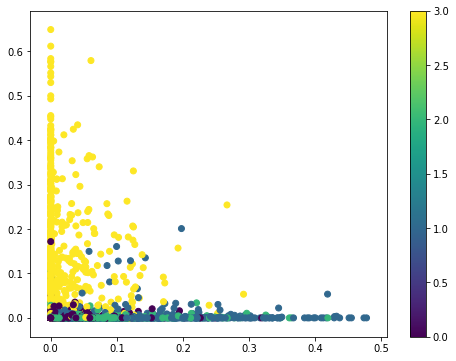

In [21]:
plt.figure(figsize=(8, 6))
plt.scatter(Z[:, 0], Z[:, 3], c = y)
plt.colorbar()

## 4. Analysis

In [11]:
invocab = dict([(vv,kk) for kk, vv in tfidf_vectorizer.vocabulary_.items()])

for i in range(q):
    insens_idx = np.argsort(W_q[i])

    print ('TOPIC ' + str(i))
    print (' '.join([invocab[w_ix] for w_ix in insens_idx[-10:]]) + '\n')

TOPIC 0
posting ed bike hp east writes dod article sun com

TOPIC 1
surrender cadre shameful dsl edu cs gordon banks geb pitt

TOPIC 2
nntp se posting simms quadra monitor drive edu mac apple

TOPIC 3
bible love mary heaven faith lord sin christ jesus god

TOPIC 4
guest ibm services mail information jim mac jon com netcom

TOPIC 5
nntp ride canada dod bc ac uk bike bnr ca

TOPIC 6
programs athens mcovingt covington michael university georgia uga ai edu

TOPIC 7
reaction foods berkeley steve superstition dyer chinese sensitivity food msg

TOPIC 8
pain ve edu think people time just like don hell

TOPIC 9
true faith believe people bible christianity church christian truth christians

